In [187]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import math
from collections import Counter
import matplotlib.pyplot as plt
import statistics

# Read and Combine Data

In [4]:
languages = ['chinese', 'german', 'french', 'thai', 'japanese', 'spanish', 'italian', 'korean', 'russian', 'portuguese']
languageColumns = ['Author', 'Date', 'Rating', 'AuthorKarma']

In [5]:
dfs = []
for language in languages:
    d = pd.read_csv('data/' + language + '.csv')
    d['originalLanguage'] = language
    
    for column in languageColumns:
        d['original' + column] = d[language + column]
        d = d.drop([language + column], axis=1)
    
    dfs.append(d)

data = pd.concat(dfs, axis=0, ignore_index=True)
    

In [87]:
len(data)

219

In [111]:
# add the texts
data['originalText'] = data.apply(lambda x: open('data/' + x['originalLanguage'] + "Originals/" + x['scpId'] + '.txt').read(), axis=1)
data['englishText'] = data.apply(lambda x: open('data/englishFrom' + x['originalLanguage'].capitalize() + "/" + x['scpId'] + '.txt').read(), axis=1)

In [112]:
data.head()

,scpId,href,name,englishRating,englishDate,englishAuthor,englishAuthorKarma,originalLanguage,originalAuthor,originalDate,originalRating,originalAuthorKarma,originalText,englishText
0,SCP-CN-1000,/scp-cn-1000,2300,"+12,+12,+12,+12",29 Mar 2019 00:01,Cynthia7979,very high,chinese,Infas12,30 Oct 2018 15:25,"+574,+574,+574,+574",very high,\n \n\n\n\n\n\n\n评分: +5...,\n \n\n\n\n\n\n\nrating...
1,SCP-CN-994,/scp-cn-994,I See You,+26,18 Mar 2018 07:50,W Asriel,guru,chinese,AndyBlocker,11 Mar 2018 01:28,+858,high,\n \n\n评分: +858+–x\n\n\...,\n \n\nrating: +26+–x\n...
2,SCP-CN-918,/scp-cn-918,NaN,+4,04 May 2018 14:48,Idokoe,high,chinese,qjfoidnh,29 Apr 2018 15:46,+49,very high,\n \n\n评分: +49+–x\n\n\n...,\n \n\nrating: +4+–x\n\...
3,SCP-CN-844,/scp-cn-844,The Seed of Lovesickness,0,20 Jul 2018 07:09,Cynthia7979,very high,chinese,Cynthia7979,02 Jun 2018 14:48,+19,very high,\n \n\n评分: +19+–x\n项目编号...,\n \n\nrating: 0+–x\nIt...
4,SCP-CN-767,/scp-cn-767,Chart Syndrome,+11,10 Aug 2018 14:28,KirkeStein,high,chinese,breaddddd,15 Feb 2018 09:08,+118,very high,\n \n\n评分: +118+–x\n\n\...,\n \n\nrating: +11+–x\n...


# Clean the Data

In [218]:
cleaned = data.drop(['name', 'href'], axis=1)

In [219]:
# fix up ratings
ratingColumns = ['originalRating', 'englishRating']
for column in ratingColumns:
    cleaned[column] = cleaned[column].map(lambda x: float(str(x).split(',')[0]))
    mask = cleaned[column].apply(lambda x: not math.isnan(x))
    cleaned = cleaned[mask]

In [220]:
# tokenize the text
#charLanguages = ['chinese', 'japanese', 'korean', 'thai']
#charLanguages = []
charLanguages = ['chinese', 'japanese', 'thai']
cleaned['englishText'] = cleaned['englishText'].apply(lambda x: x.split())
cleaned['originalText'] = cleaned.apply(lambda x: list(x['originalText']) if x['originalLanguage'] in charLanguages else x['originalText'].split(), axis=1)

In [221]:
cleaned.head()

,scpId,englishRating,englishDate,englishAuthor,englishAuthorKarma,originalLanguage,originalAuthor,originalDate,originalRating,originalAuthorKarma,originalText,englishText
0,SCP-CN-1000,12.0,29 Mar 2019 00:01,Cynthia7979,very high,chinese,Infas12,30 Oct 2018 15:25,574.0,very high,"[\n, , , , , , , , , , , , , , ,...","[rating:, +12+–x, rating:, +12+–x, Credits, Or..."
1,SCP-CN-994,26.0,18 Mar 2018 07:50,W Asriel,guru,chinese,AndyBlocker,11 Mar 2018 01:28,858.0,high,"[\n, , , , , , , , , , , , , , ,...","[rating:, +26+–x]"
2,SCP-CN-918,4.0,04 May 2018 14:48,Idokoe,high,chinese,qjfoidnh,29 Apr 2018 15:46,49.0,very high,"[\n, , , , , , , , , , , , , , ,...","[rating:, +4+–x, SCP-CN-918, in, motionless, s..."
3,SCP-CN-844,0.0,20 Jul 2018 07:09,Cynthia7979,very high,chinese,Cynthia7979,02 Jun 2018 14:48,19.0,very high,"[\n, , , , , , , , , , , , , , ,...","[rating:, 0+–x, Item, #:, SCP-CN-844, Object, ..."
4,SCP-CN-767,11.0,10 Aug 2018 14:28,KirkeStein,high,chinese,breaddddd,15 Feb 2018 09:08,118.0,very high,"[\n, , , , , , , , , , , , , , ,...","[rating:, +11+–x, +, Containment, Record, -, C..."


# Math and Stuff

In [222]:
df = cleaned

In [223]:
df['originalEntropy'] = df.apply(lambda x: entropy(list(map(lambda y: y / len(x['originalText']), Counter(x['originalText']).values()))), axis=1)

In [224]:
df['englishEntropy'] = df.apply(lambda x: entropy(list(map(lambda y: y / len(x['englishText']), Counter(x['englishText']).values()))), axis=1)

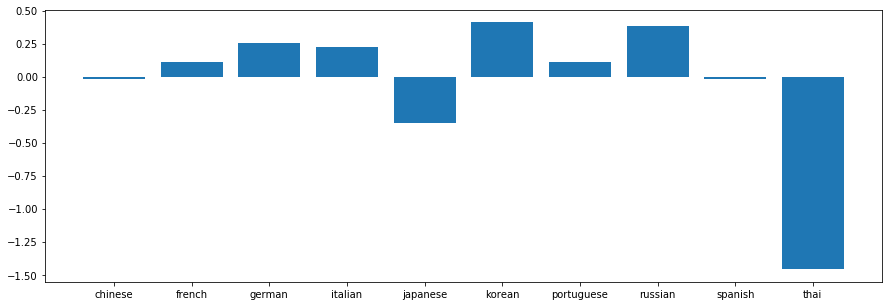

In [225]:
originalEntropy = df.groupby('originalLanguage').apply(lambda x: statistics.mean(x['originalEntropy']))
englishEntropy = df.groupby('originalLanguage').apply(lambda x: statistics.mean(x['englishEntropy']))

y_pos = np.arange(len(languages))
plt.figure(figsize=(15,5))
plt.bar(y_pos, originalEntropy.values  - englishEntropy.values)
plt.xticks(y_pos, originalEntropy.index)
plt.show()